In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy


/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_file = 'val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'bs_32_val_err.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 12
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

<IPython.core.display.Javascript object>

In [3]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*20
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//20+1])
# earlyStoppingStep = 9220

9220 0.32954545454545453 505
9640 0.3433636340227994


In [4]:
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
err = val_err-whole_a*np.power(steps,whole_b)
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

plt.figure()
whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
ax = plt.subplot()
ax.plot(steps[100:], err[100:])
err_a, err_b = np.linalg.lstsq(np.vstack([steps[100:], np.ones(len(steps[100:]))]).T, err[100:], rcond=None)[0]
ax.plot(steps[100:], err_a*steps[100:] + err_b)

res = err[100:] - err_a*steps[100:] - err_b

plt.figure()
_ = scipy.stats.probplot(res, dist=scipy.stats.rayleigh, plot=plt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
plt.figure()
plt.plot(steps, val_err)

fun = lambda x: np.sum(np.power(val_err-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]*(steps-x[3])),2))
bnds = ((0, None), (None, 0), (0, None),(0, None))
res = scipy.optimize.minimize(fun, (1,0,0,8000), method='TNC', bounds=bnds)

plt.plot(steps,(res.x[0]*np.power(steps, res.x[1])+res.x[2]*(steps-res.x[3])))


<IPython.core.display.Javascript object>

In [6]:
"""
Predict the early stopping epoch by "adding-noise" method
input: 
    a, b: y = ax^b
    var: the variance of unsmoothed data
    min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
    smooth_win_size: the window size for smoothing
    num_samples: how many samples to generate when using bootstrapping
    upper_limit: only consider the predicted epoch smaller than upper_limit
    lower_limit: only consider the predicted epoch larger than upper_limit
return:
    mean: mean of all predicted epochs
    stopping_epochs: all predicted epochs
    sample: one of the sythetic data
    smoothed_sample: smoothing the sythetic data
"""
def early_stopping_prediction_adding_noise(a,b,d,var,min_delta,patience, 
                                           num_epochs_between_eval,
                                           smooth_win_size,
                                           num_samples=100,
                                           upper_limit=2e4,
                                        lower_limit=0
                                          ):
    num_points = int((upper_limit-lower_limit) // num_epochs_between_eval) # the number of noisy points we want to generate
#     s = int(lower_limit //num_epochs_between_eval)
    
#     x = np.arange(s,num_points+s)*num_epochs_between_eval
    x = np.linspace(lower_limit, upper_limit, num_points) 
    y = a*np.power(x,b) + d*(x-x[0])
        
    stopping_epochs = [] 
    for i in range(num_samples):
#         noise = np.random.normal(0, np.sqrt(var), num_points)
        noise = np.random.rayleigh(np.sqrt((4-np.pi)/2*var), num_points) - var*np.sqrt(np.pi/2)
        z = y + noise
        
        if i == 0:
            sample = z
            smoothed_sample = smooth_by_linear_filter(z, smooth_win_size)
        
        try:
            stopping_epochs.append(
                early_stopping_step(z, min_delta, patience, smooth_win_size, num_epochs_between_eval) + lower_limit)
        except:
            continue
    
    return np.mean(stopping_epochs), np.array(stopping_epochs), sample, smoothed_sample

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [20]:
'''
simulate early stopping prediction
input:
    data: the data that used to predict the epoch
    smooth_win_size: window size for smoothing
    epochs_between_eval: number of epochs between two evals
    min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
    pred_win_size: the window size for epoch prediction, wrt points not real epochs
    left_tail_size: the window where the data should be weighted (< 1) when doing regression, 
                    wrt points not real epochs
    period: the period for prediction, wrt points not real epochs
    start_point: at which point we start the first prediction, wrt points not real epochs
    weights_type: the type of weights
                    linear: the weights are linear from 0-1 within the left_tail_size
                    equal: the weights are 1 within the left_tail_size
    num_samples: how many samples to generate when predicting the epoch by bootstrapping
    upper_limit: only consider the predicted epoch smaller than upper_limit when doing bootstarpping
output:
    preds: predicted epochs
    coeffs: regression coeffients (a,b)
    shifts: the distance that we translation the piece curve to make it close to x-axis
    sample: the sythetic data for each piece curve
    smoothed_sample: smoothing the sythetic data
    CIs: 95% confidence intervals    
'''
def sim_online_early_stopping_prediction_adding_noise(
                                        data, 
                                        smooth_win_size,
                                         epochs_between_eval, 
                                         min_delta, patience, 
                                         pred_win_size, 
                                         left_tail_size, 
                                         period,
                                         bounds, inits, method='TNC',
                                         start_point=100, 
                                         weights_type='linear',
                                        num_samples=100,
                                        upper_limit=2e4):
    ########################################
    global_step = 0
    ########################################
    # generate weights
    w1_size = pred_win_size - left_tail_size # the number of elements we assign weight 1
    if weights_type == 'linear':
        basic_weights0 = np.linspace(0,1,left_tail_size)
    elif weights_type == 'equal':
        basic_weights0 = np.ones(left_tail_size)
    basic_weights1 = np.ones(w1_size)
    basic_weights = np.concatenate((basic_weights0, basic_weights1))
    def weights_generator(length):
        if length <= w1_size:
            rst = np.ones(length)
        elif length <= pred_win_size:
            s = pred_win_size - length
            rst = basic_weights[s:]
        else:
            z = np.zeros(length - pred_win_size)
            rst = np.concatenate((z, basic_weights))

        return rst
    preds = []
    coeffs = []
    shifts = []
    samples = []
    smoothed_samples = []
    CIs = []
    vars_ = []
    pred = 0
    upper_limits = []
    lower_limits = []
        ########################################
    for i in range(len(data)):
#         print(i)
        global_step += epochs_between_eval
    
        ###############################
        # save time, should be deleted in practice
        if global_step > earlyStoppingStep:
            break
        ###############################
        ########################################
        num_evals = global_step//epochs_between_eval

        if num_evals >= start_point and (num_evals-start_point)%period == 0:
            print(global_step)
            if num_evals < pred_win_size:
                s = 0
            else:
                s = num_evals - pred_win_size
            e = num_evals
            
            # no shift
            steps = (np.arange(s,e)+1) * epochs_between_eval
            shift = steps[-1]
            # shift the piece of curve 
#             x = (np.arange(0,e-s)+1) * epochs_between_eval
#             shift = s*epochs_between_eval
            y = data[s:e]
            weights = weights_generator(len(y))
            
#             a, b = power_regression(x, y, weights)
            fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]**2*(steps-steps[0])),2))
            res = scipy.optimize.minimize(fun, inits, method=method, bounds=bounds)
            a = res.x[0]
            b = res.x[1]
            d = res.x[2]**2
            var = np.var(y-(a*np.power(steps,b)+d*(steps-steps[0])))
            
            last_pred = pred

            lower_limit=steps[-1]
            num_points = int((upper_limit-lower_limit) // num_epochs_between_eval)
            x = np.linspace(lower_limit, upper_limit, num_points) 
            y = a*np.power(x,b) + d*(x-x[0])
#             try:
#             print(len(y))
            pred = early_stopping_step(y, min_delta, patience, 0, num_epochs_between_eval) + lower_limit
#             except:
#                 continue
            print(pred, a,b,d,var,min_delta,patience,epochs_between_eval,smooth_win_size,num_samples,upper_limit)
            
#             _, CI_left, CI_right = mean_confidence_interval(stopping_epochs)
            
            # what if the predicted epoch is smaller than the current epoch
            ## use the previous predicted epoch
            ## if still smaller, use the current epoch
            ## CI is meaningless in this case
#             if pred < (e+1) * epochs_between_eval:
#                 pred = last_pred
#                 if pred < (e+1) * epochs_between_eval:
#                     pred = (e+1) * epochs_between_eval
#                 CI_left = 0
#                 CI_right = 0
                
            # we should do this because we shift the curve before
#             pred += s*epochs_between_eval
            preds.append(pred)
#             CIs.append((CI_left, CI_right))
            coeffs.append((a,b))
            shifts.append(shift)
#             samples.append(sample)
#             smoothed_samples.append(smoothed_sample)
            
            
            vars_.append(var)
                        

    return preds, coeffs, shifts, vars_

def CIs2errs(CIs):
    errs = []
    for ci in CIs:
        errs.append((ci[1]-ci[0])/2)
    
    return np.array(errs)


pred_win_size = 1000
left_tail_size = 0
period = 20
start_point = 80
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000
bnds = ((0, None), (None, 0), (None, None))
inits = (1,0,1)

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5

# set a effective upper limit
# upper_limit_bias = 80
# upper_limit = (len(val_err) + upper_limit_bias)*num_epochs_between_eval
preds_with_patience = []
errs_with_patience = []

patiences = range(8,13)
for patience in patiences:
    preds, coeffs, shifts, _ = sim_online_early_stopping_prediction_adding_noise(
                                        val_err,
#                                         whole_smoothed_val_err,
                                        smooth_win_size,
                                         num_epochs_between_eval, 
                                         pred_min_delta,
                                         patience,
                                        pred_win_size = pred_win_size,
                                        left_tail_size = left_tail_size,
                                        period = period,
                                        bounds=bnds, inits=inits,
                                        start_point = start_point,
                                        weights_type = wtype,
                                        num_samples=1000,
                                        upper_limit=upper_limit)
    print(len(preds))

#     errs = CIs2errs(CIs)
    
    preds_with_patience.append(preds)
#     errs_with_patience.append(errs)


# plt.figure()
# x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
# plt.errorbar(x, preds-x, errs, fmt='.-')

1600
3040 1.540345899376899 -0.11891791360420337 6.6943179737192955e-12 0.008271442432548477 0.0005 8 20 55 1000 200000.0
2000
3460 1.8386524456150735 -0.1531796745937156 2.434761010513886e-10 0.010997014011922277 0.0005 8 20 55 1000 200000.0
2400
3680 2.0766978146510815 -0.1765969572912704 9.370693422712377e-13 0.011807937265014197 0.0005 8 20 55 1000 200000.0
2800
3740 2.1761499804056506 -0.18522679566255695 2.7646262392570974e-08 0.011132290356462739 0.0005 8 20 55 1000 200000.0
3200
3840 2.33615647298164 -0.19890357419555696 9.144691363893028e-13 0.01073025995312532 0.0005 8 20 55 1000 200000.0
3600
3880 2.435701896098684 -0.206700372076929 1.8739340622594551e-16 0.010299335243532094 0.0005 8 20 55 1000 200000.0
4000
4200 2.5401257163387276 -0.21449274153132183 1.4239294216553508e-13 0.009910085361339405 0.0005 8 20 55 1000 200000.0
4400
4600 2.5679941612089863 -0.21672102473448968 1.1953536915512435e-12 0.009301173448617724 0.0005 8 20 55 1000 200000.0
4800
5000 2.6022078381101226

4660 2.5679941612089863 -0.21672102473448968 1.1953536915512435e-12 0.009301173448617724 0.0005 11 20 55 1000 200000.0
4800
5060 2.6022078381101226 -0.21886423696096943 1.355942263504913e-14 0.008658355613297981 0.0005 11 20 55 1000 200000.0
5200
5460 2.63844122770592 -0.22134214060215854 4.72440918964105e-15 0.008166231971277966 0.0005 11 20 55 1000 200000.0
5600
5860 2.6717631410331943 -0.22355179941885497 1.1332430057462895e-11 0.00781403216880904 0.0005 11 20 55 1000 200000.0
6000
6260 2.6935029391549326 -0.22503245601077634 2.086291467220077e-15 0.007424365733721388 0.0005 11 20 55 1000 200000.0
6400
6660 2.6782761589974173 -0.22421231312637707 8.210448805849214e-13 0.007160036901140322 0.0005 11 20 55 1000 200000.0
6800
7060 2.5747417983950562 -0.21992378837464457 1.9609170710509167e-09 0.006903498853149807 0.0005 11 20 55 1000 200000.0
7200
7460 2.664995530393589 -0.22476521118232012 1.1556880135209784e-09 0.006634880584525989 0.0005 11 20 55 1000 200000.0
7600
7860 2.7946576626

<IPython.core.display.Javascript object>


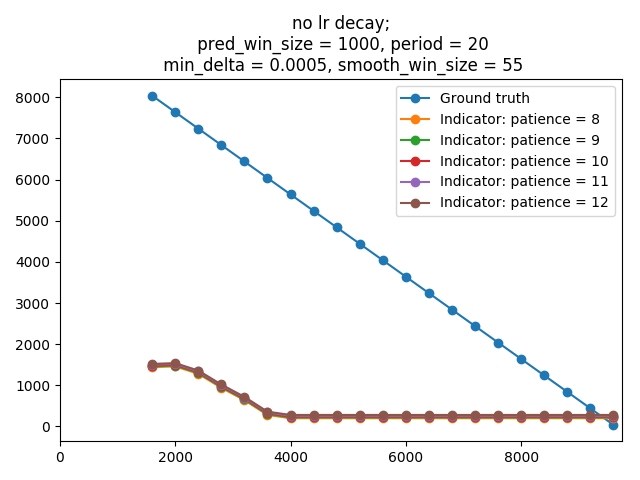

[1600 2000 2400 2800 3200 3600 4000 4400 4800 5200 5600 6000 6400 6800
 7200 7600 8000 8400 8800 9200 9600]


In [21]:
fig = plt.figure()

x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
print(x)

plt.plot(x, earlyStoppingStep-x,'-o')

legend = ['Ground truth']
for i, v in enumerate(patiences):
    plt.plot(x, preds_with_patience[i]-x, '-o')
    legend.append('Indicator: patience = {}'.format(v))
plt.xlim(0,earlyStoppingStep+100)
# plt.ylim(0, 2000)
# plt.errorbar(x, preds-x, errs, fmt='.-')
# plt.legend(['Ground truth', 'KF indicator: patience = 8, min_delta = 1e-5'])
plt.legend(legend)
plt.title('no lr decay;\n pred_win_size = {0}, period = {1}\n min_delta = {2}, smooth_win_size = {4}'.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()


plt.savefig('result_figs/baseline.png')

In [10]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 4
for i in range(0,len(coeffs),step_size):
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
#     ax.plot(steps, val_err)
    ax.plot(steps[:len(whole_smoothed_val_err)], whole_smoothed_val_err)
    x = np.arange(1,len(smoothed_samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x+shifts[i],smoothed_samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,20000)
    
fig.tight_layout()   

<IPython.core.display.Javascript object>

NameError: name 'smoothed_samples' is not defined